# Optimizing analysis parameters $L$ and $\epsilon^2$

In [1]:
using divand
using PyPlot

## Data reading

In [4]:
varname = "Salinity"
filename = "WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity");

### Topography and grid definition

See the notebook on [bathymetry](06-topography.ipynb) for more explanations.

In [5]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = divand_rectdom(lonr,latr)

bathname = "gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end

INFO: Bathymetry file already downloaded


In [6]:
bx,by,b = load_bath(bathname,true,lonr,latr)

mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

## Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth ranges. Here August data at surface:

ADDITIONTAL PARAMETER TO BE USED LATER

In [7]:
datadepth=1
depthprecision=0.5

0.5

Note that we added test on value to eliminate obvious outliers

In [8]:
sel = (obsdepth .< datadepth) .& (obsdepth .>= (datadepth-depthprecision)) .& (Dates.month.(obstime) .== 8) .& (obsval .> 37)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (269,)
              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.005001068115234, 43.676998138427734)
              minimum and maximum of obs. dimension 3: (0.5952349305152893, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1976-08-11T16:45:00.002, 2008-08-22T11:00:00.001)
                          minimum and maximum of data: (37.02949905395508, 38.51100158691406)


Modify data weight by taking into account close points

In [9]:
?divand.weight_RtimesOne

```
 weights = weight_RtimesOne(x,len)
```

Compute the weight of the observations at location `x` to reduce the influence  of locally clustered data.  `x` is a tuple with n elements. Every element  represents a coordinate of the observations. `len` is a tuple of arrays representing the correlation length. `len[i]` is the correlation length in the  i-th dimension.


In [10]:
rdiag=1.0./divand.weight_RtimesOne((obslon,obslat),(0.03,0.03))
@show maximum(rdiag),mean(rdiag)

(maximum(rdiag), mean(rdiag)) = (44.327708585875975, 9.079939635645088)


(44.327708585875975, 9.079939635645088)

## Analysis

Analysis `fi` using mean data as background.      
Structure `s` is stored for later use.

In [11]:
len=1
epsilon2=1
fi,s = divandrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),len,epsilon2*rdiag);

Generate some plots:
1. Analysis with data points
2. Data residuals
3. Residuals vs value

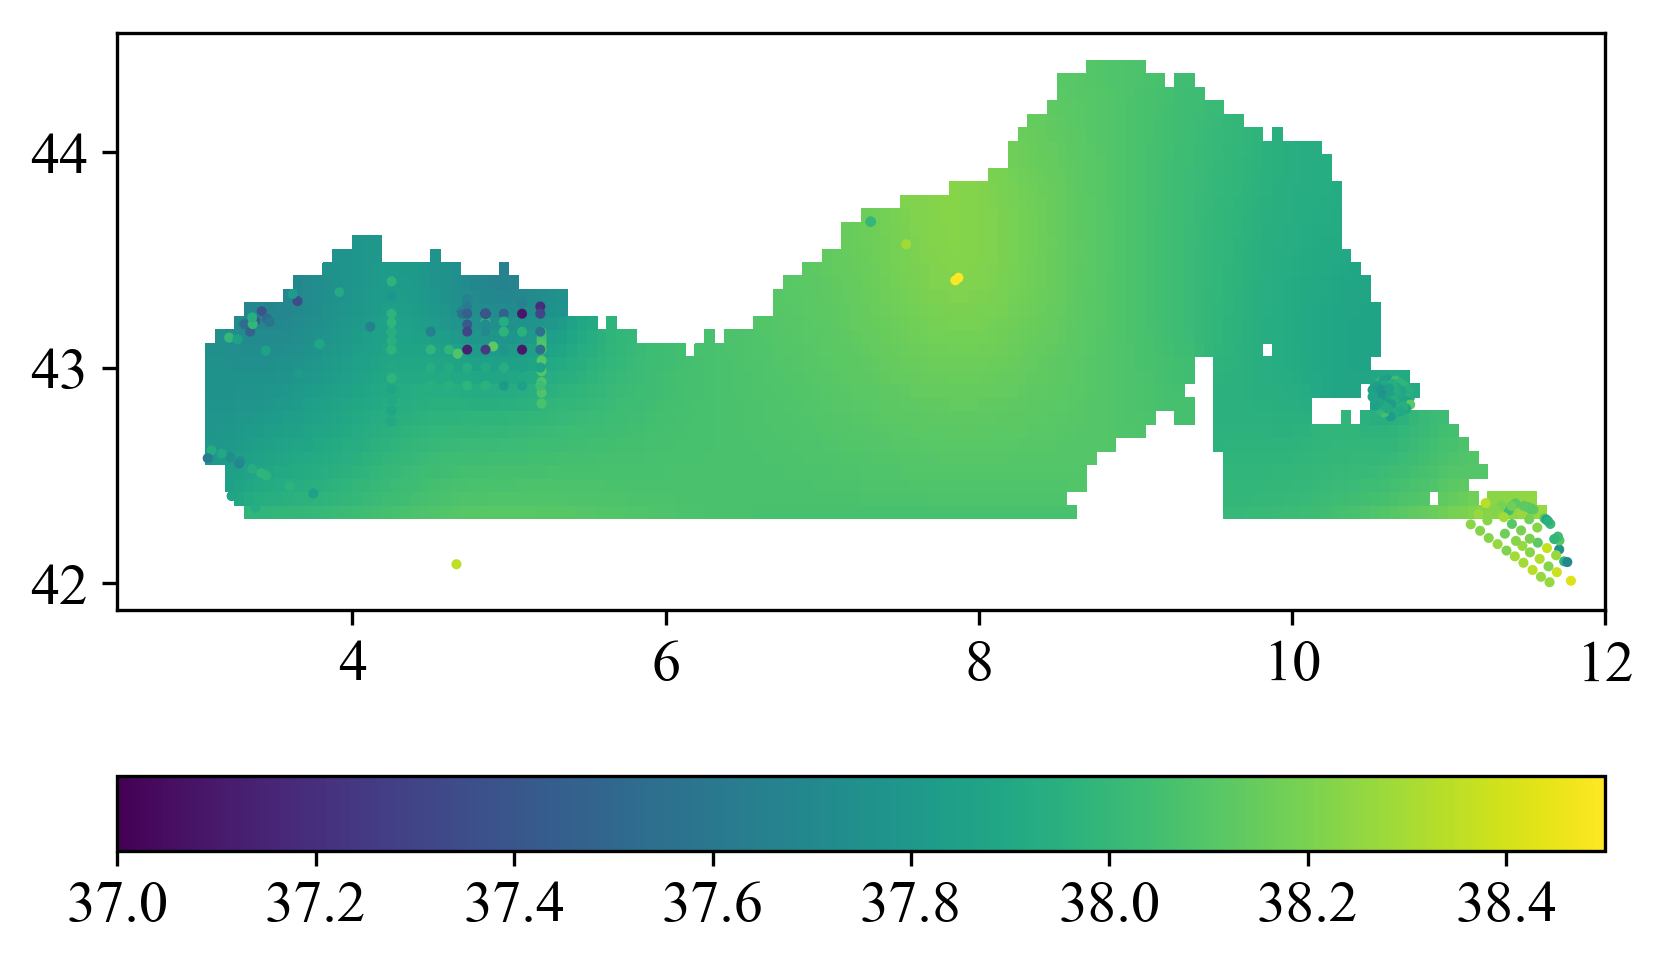

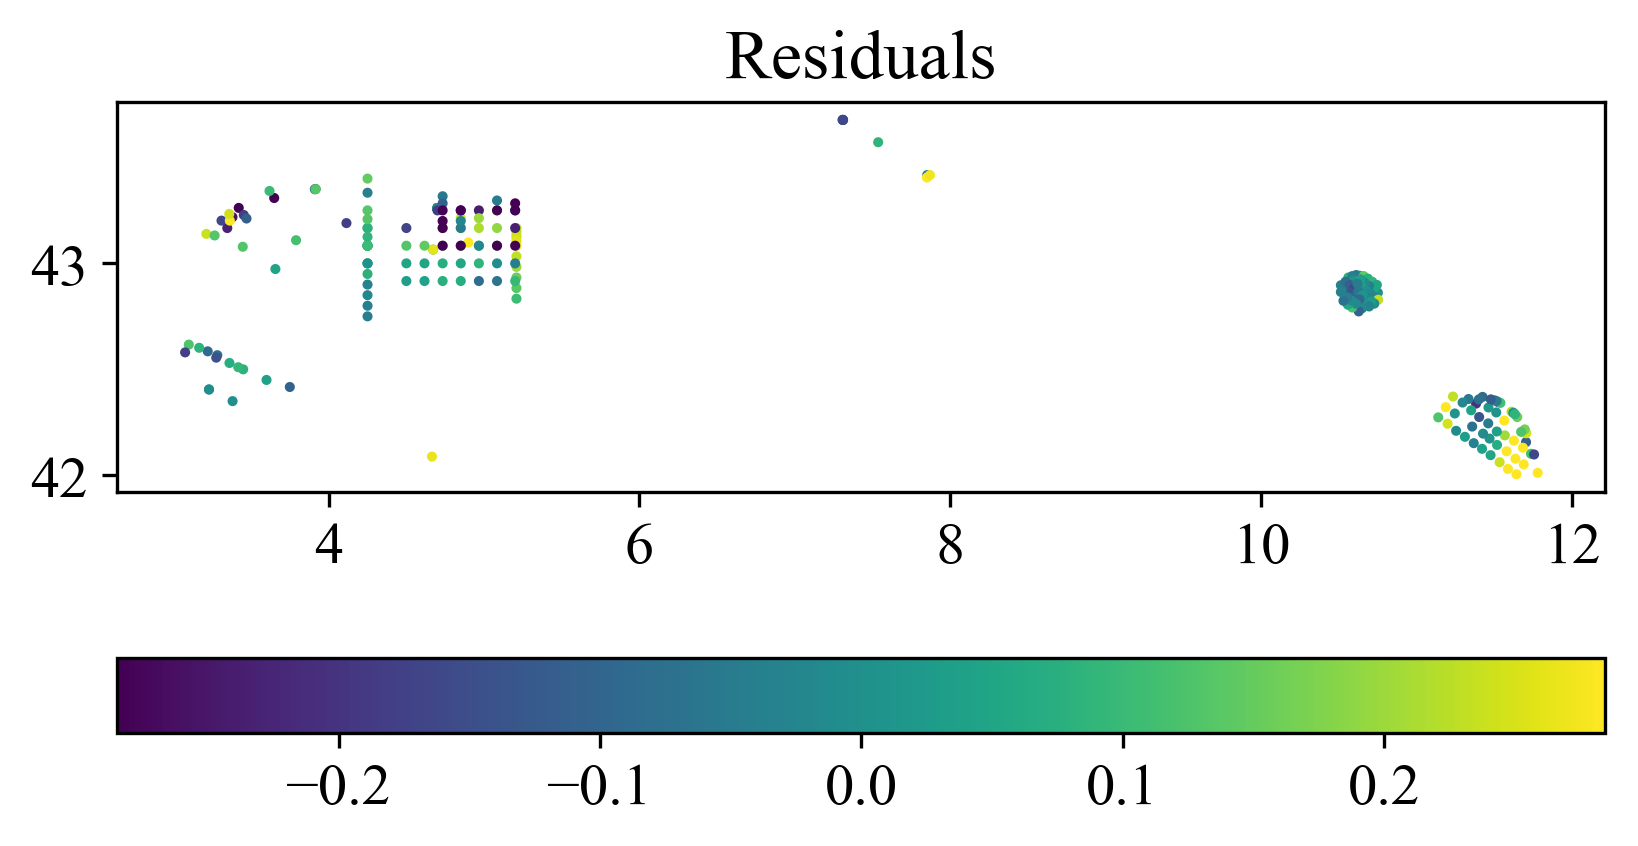

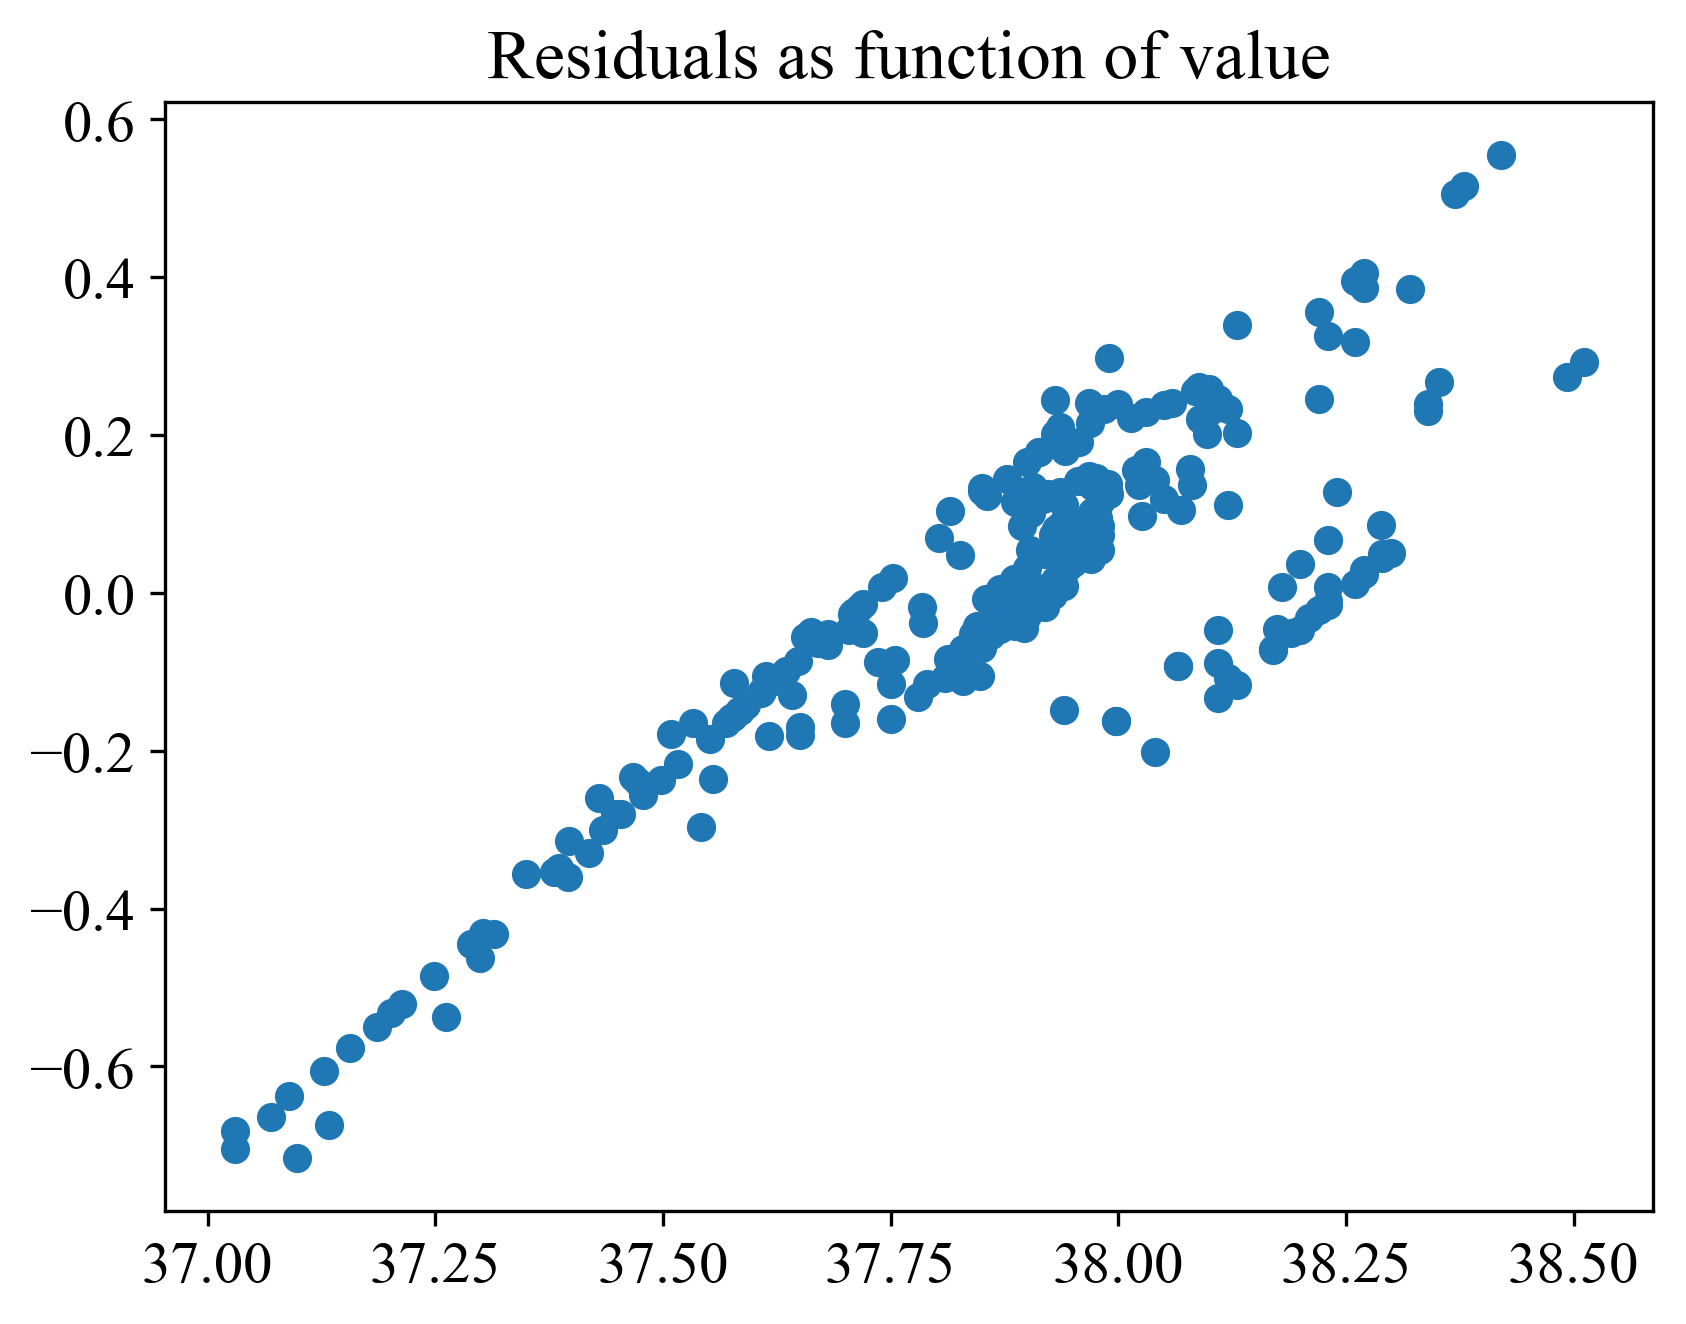

In [12]:
figure()

pcolor(xi,yi,fi+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand_residualobs(s,fi)
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5)

rscale=sqrt(var(obsval))

figure()
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

figure()
scatter(obsval,dataresiduals)
title("Residuals as function of value");

# Cross validation

Take out data and measure difference between these data points not used and the analysis. Three methods are implemented 
## Define method used
    # 1: full CV
    # 2: sampled CV
    # 3: GCV
    # 0: automatic choice between the three possible ones, default value

(bestfactorl[imeth + 1], bestfactore[imeth + 1]) = (1.9180377161692854, 0.02238721138568339)
(bestfactorl[imeth + 1], bestfactore[imeth + 1]) = (2.21673758943311, 0.02238721138568339)
(bestfactorl[imeth + 1], bestfactore[imeth + 1]) = (1.9180377161692854, 0.02238721138568339)
(bestfactorl[imeth + 1], bestfactore[imeth + 1]) = 

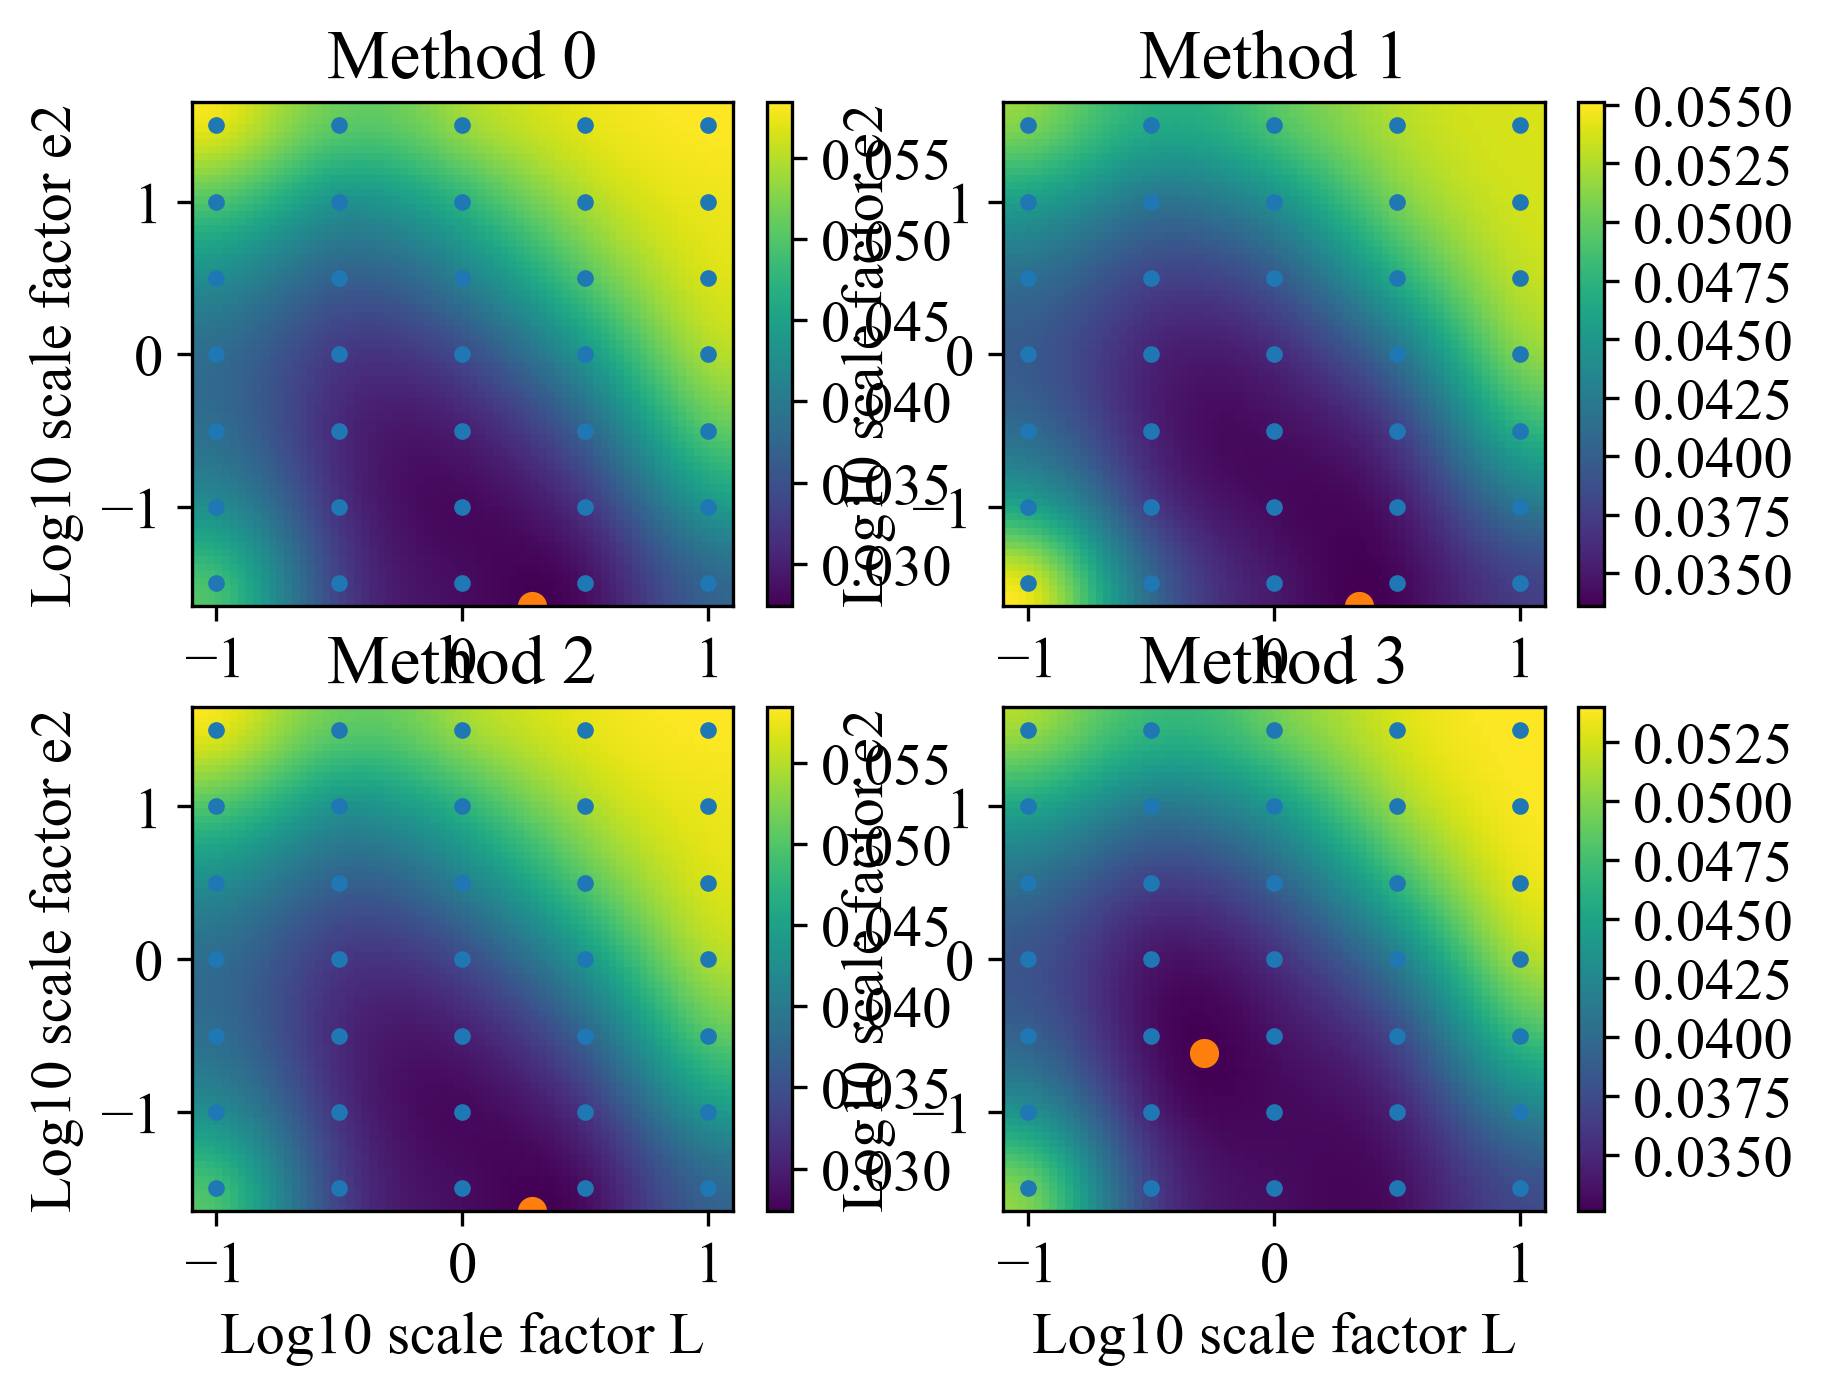

(0.5213661814728049, 0.2438612845535494)


In [14]:
bestfactorl=ones(4)
bestfactore=ones(4)
for imeth=0:3

    bestfactorl[imeth+1],bestfactore[imeth+1], cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = divand_cv(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),len,epsilon2*rdiag,2,3,imeth);
    @show bestfactorl[imeth+1],bestfactore[imeth+1]
    
    subplot(2,2,imeth+1)
    pcolor(xi2D,yi2D,cvinter)#,vmin=0,vmax=0.04)
    colorbar()
    xlabel("Log10 scale factor L")
    ylabel("Log10 scale factor e2")
    plot(x2Ddata,y2Ddata,".")
    plot(log10.(bestfactorl[imeth+1]), log10.(bestfactore[imeth+1]),"o")
    title("Method $imeth")
end

**WARNING:** any tests with resulting length scales being smaller than around 4 times the grid spacing are meaningless.

Analysis with optimized values:


In [15]:
newl=len*bestfactorl[2]
newe=epsilon2*bestfactore[2]

fi,s = divandrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),newl,newe*rdiag);

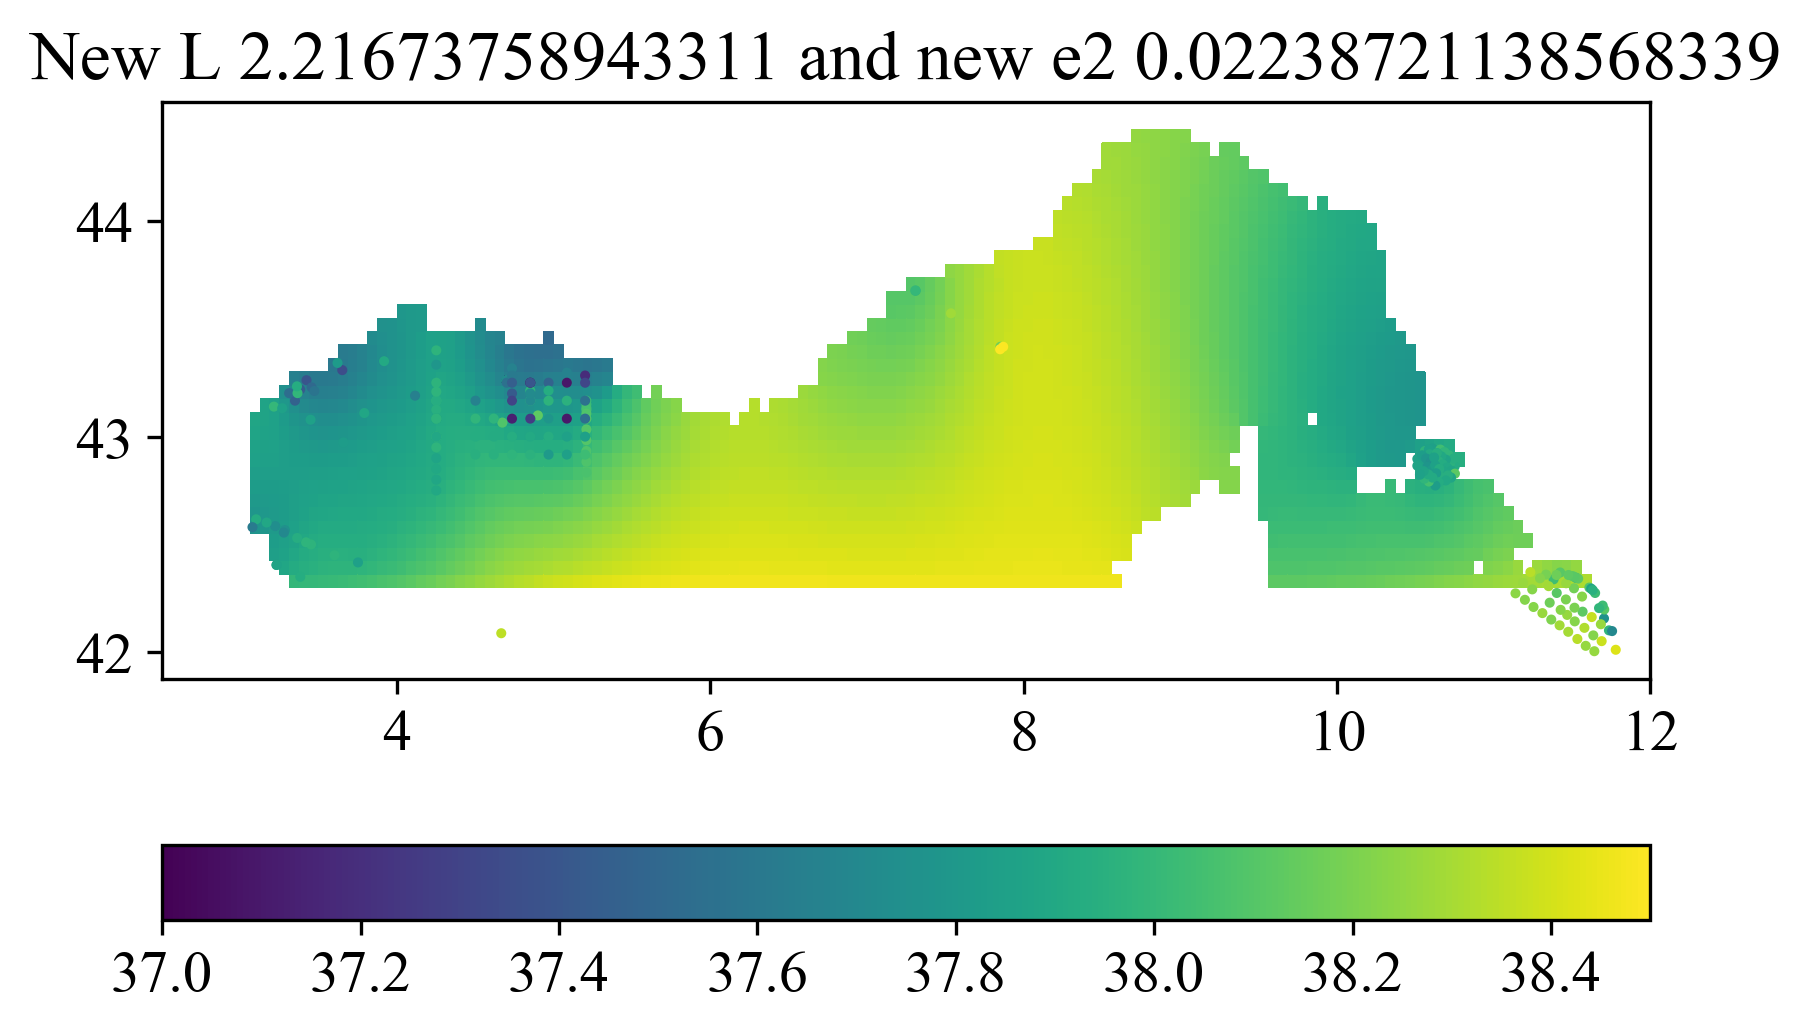

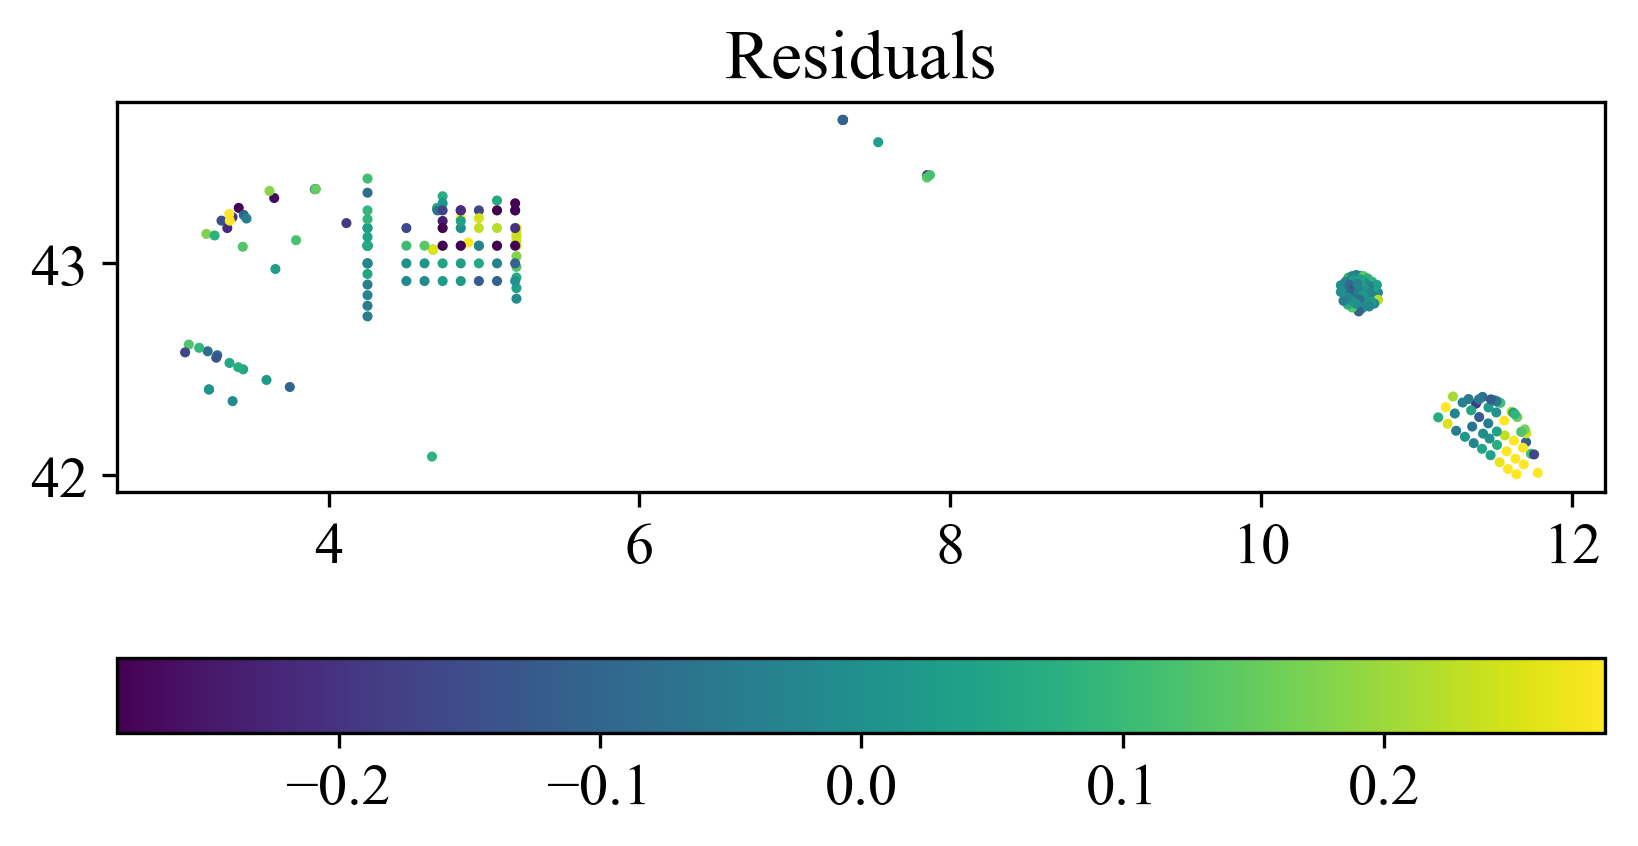

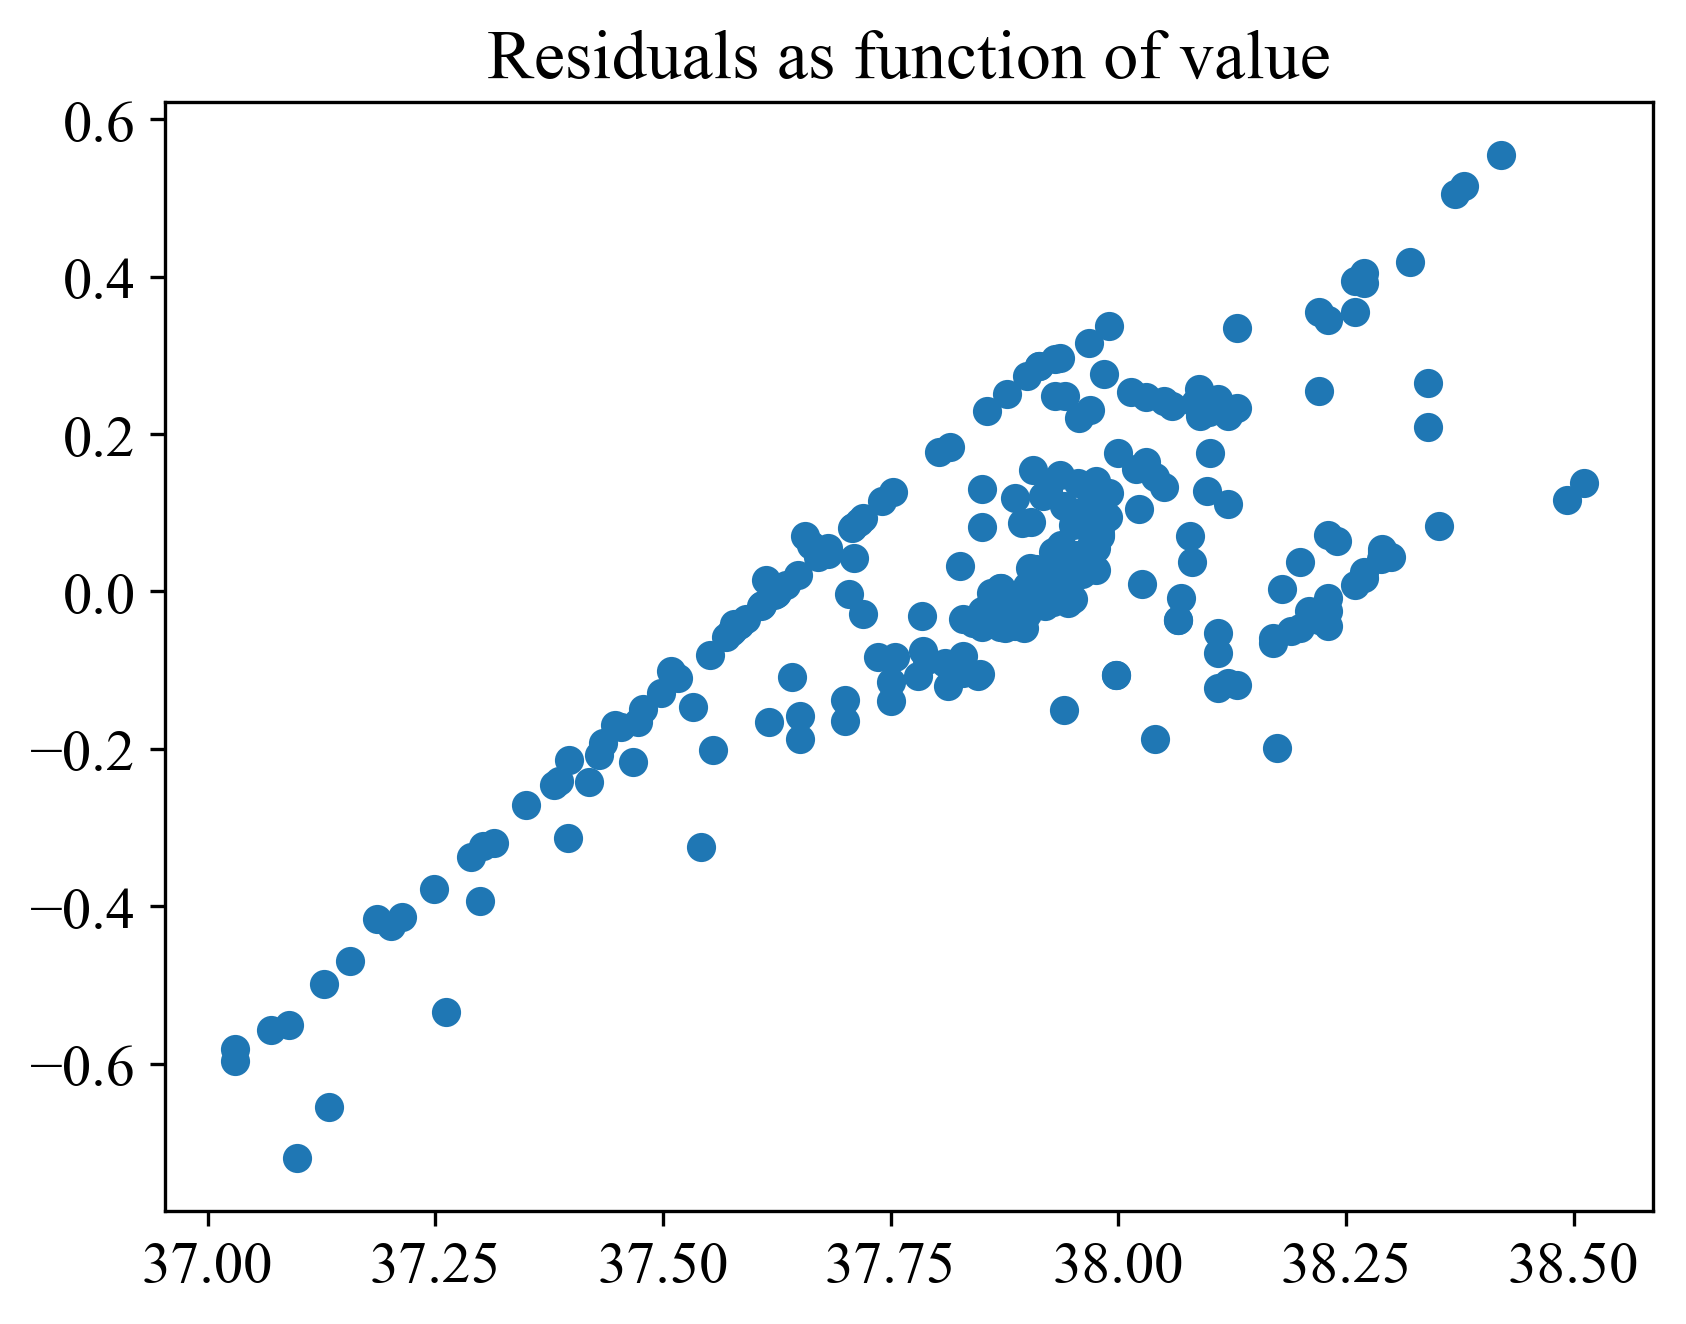

In [16]:
pcolor(xi,yi,fi+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand_residualobs(s,fi)
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5)
title("New L $newl and new e2 $newe")

rscale=sqrt(var(obsval))

figure()
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

figure()
scatter(obsval,dataresiduals)
title("Residuals as function of value");

## Only one parameter optimized

If $L$ is fixed by other calibration, you can decide to optimize only $\epsilon^2$:

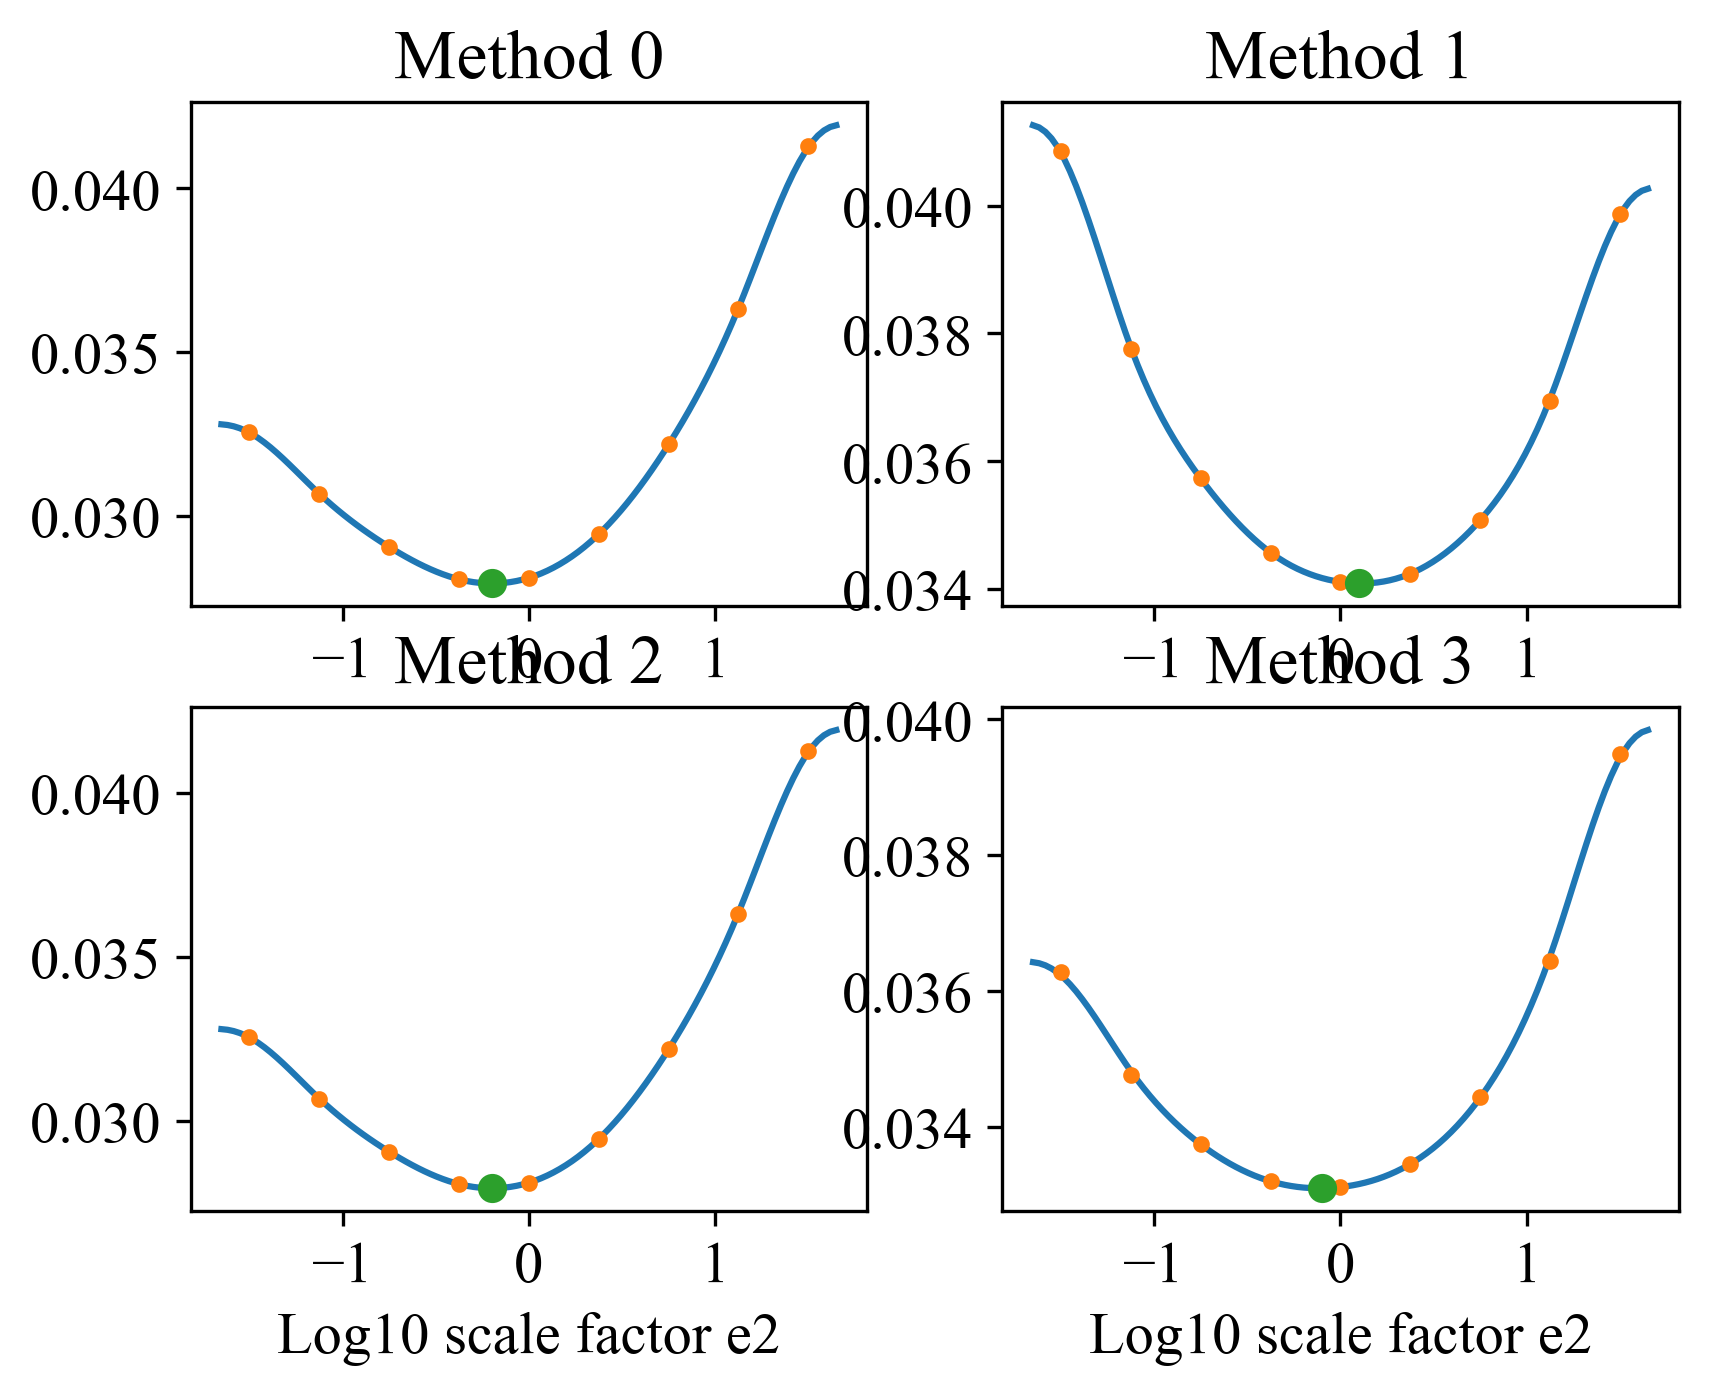

In [17]:
lenfixed=1
epsilon2=.1
for imeth=0:3
    bestfactore[imeth+1], cvval,cvvalues, x2Ddata,cvinter,xi2D = 
    divand_cv(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),lenfixed,epsilon2*rdiag,0,4,imeth);

    subplot(2,2,imeth+1)
    plot(xi2D,cvinter,"-")
    xlabel("Log10 scale factor e2")
    plot(x2Ddata,cvvalues,".")
    plot(log10.(bestfactore[imeth+1]), cvval,"o")
    title("Method $imeth")
end

In [18]:
newl=lenfixed
newe=epsilon2*bestfactore[3]
@show newe
fi,s = divandrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),newl,newe*rdiag);

newe = 0.06338697112569269


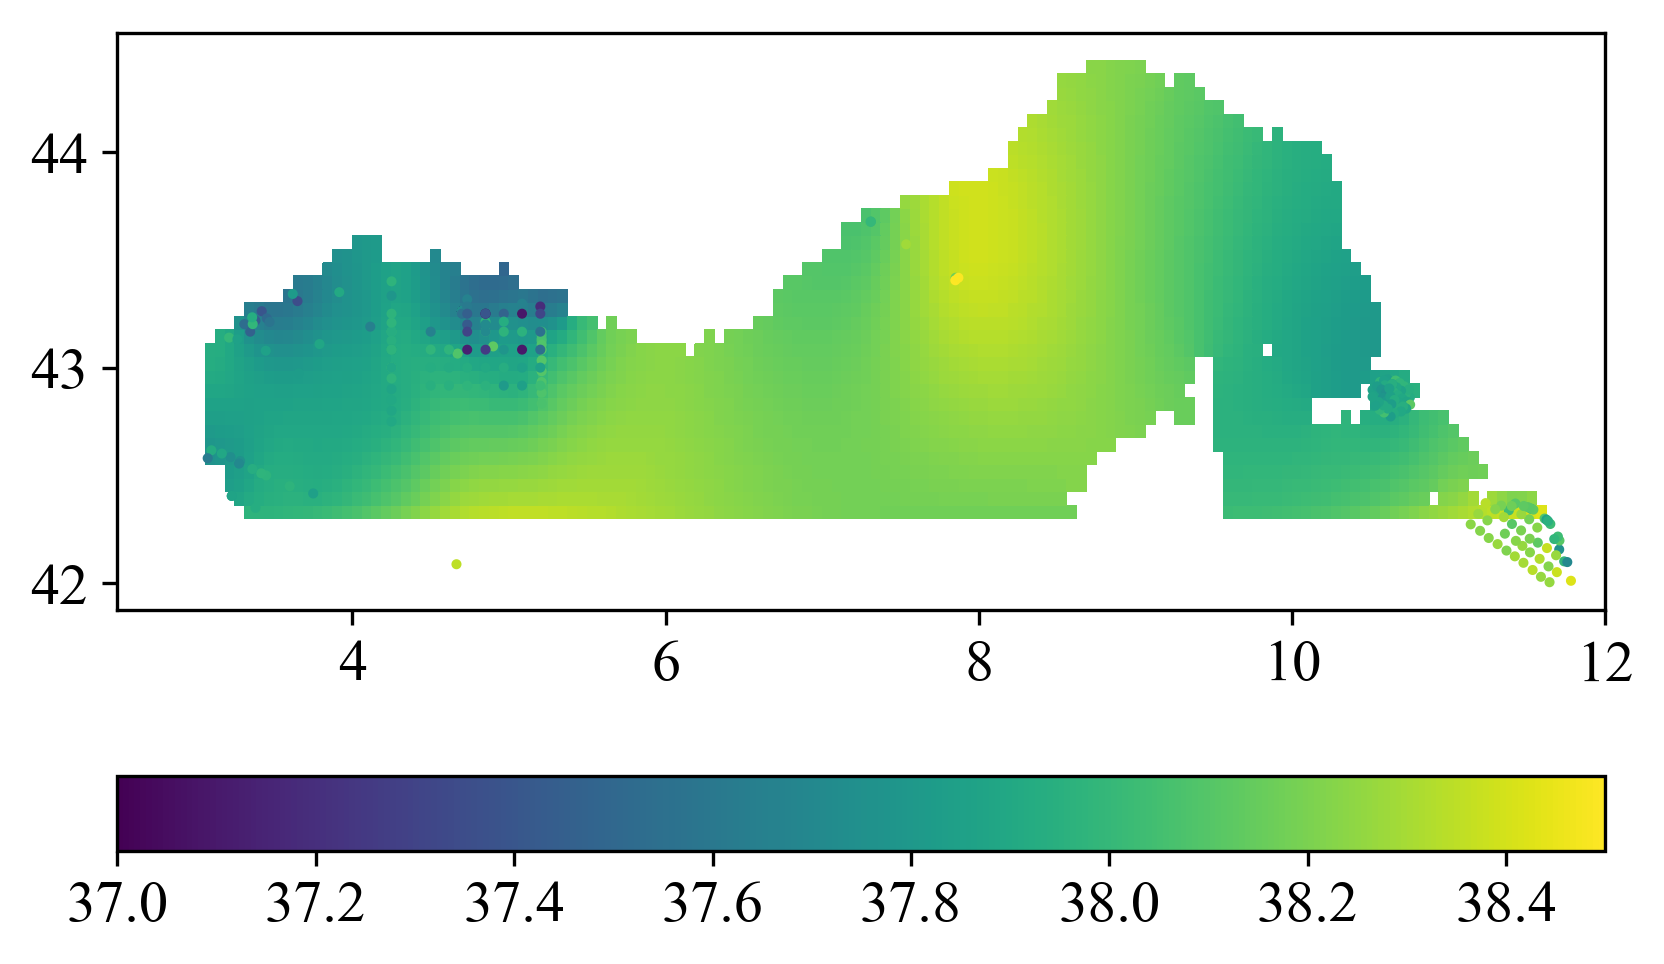

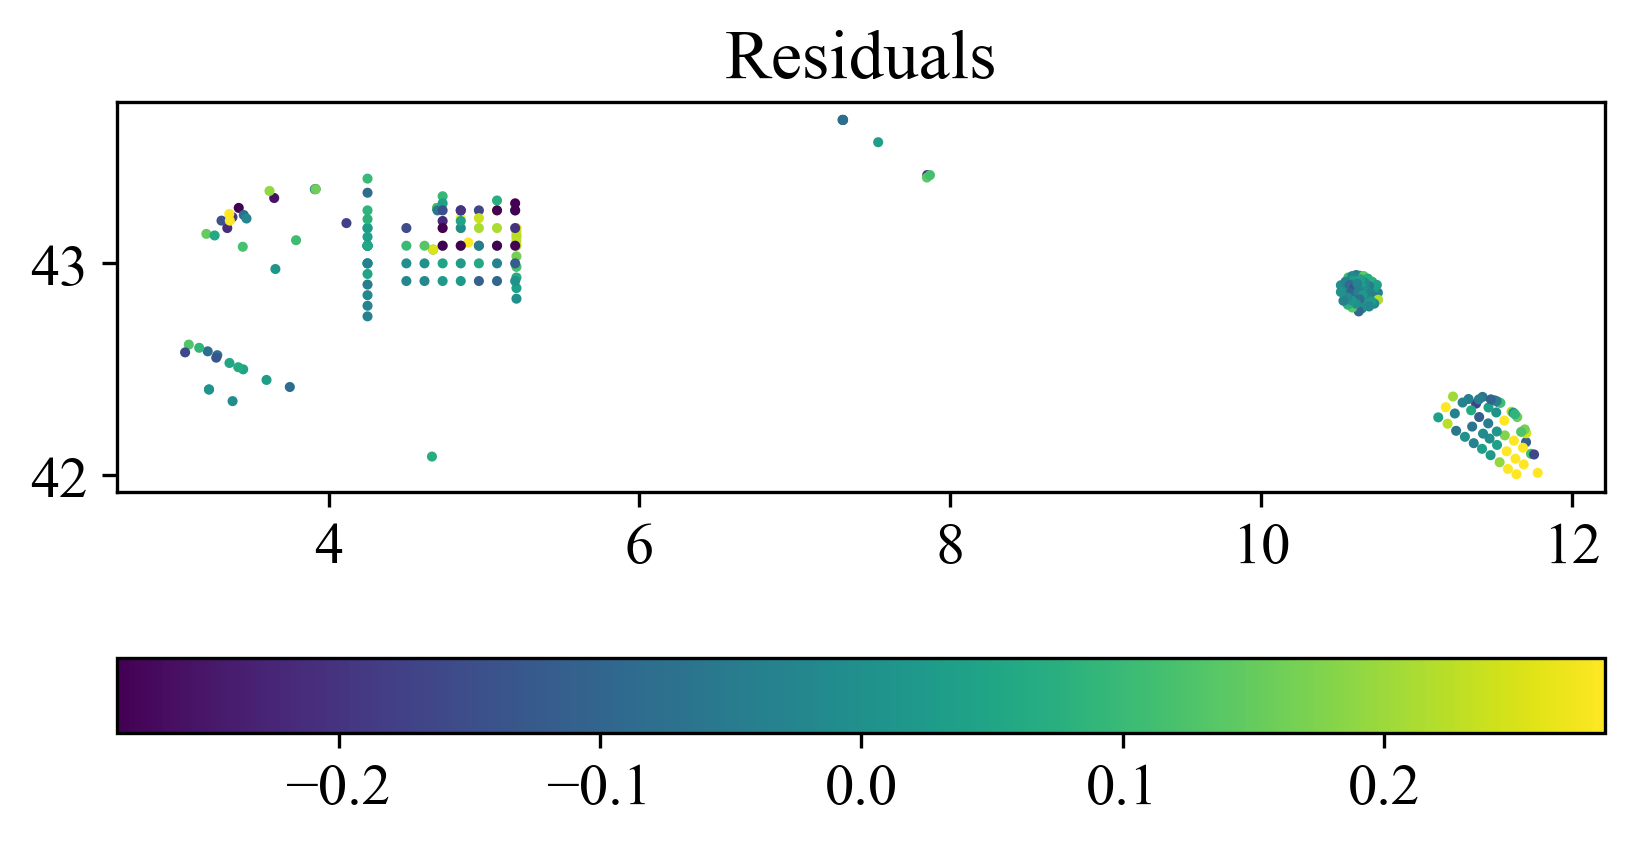

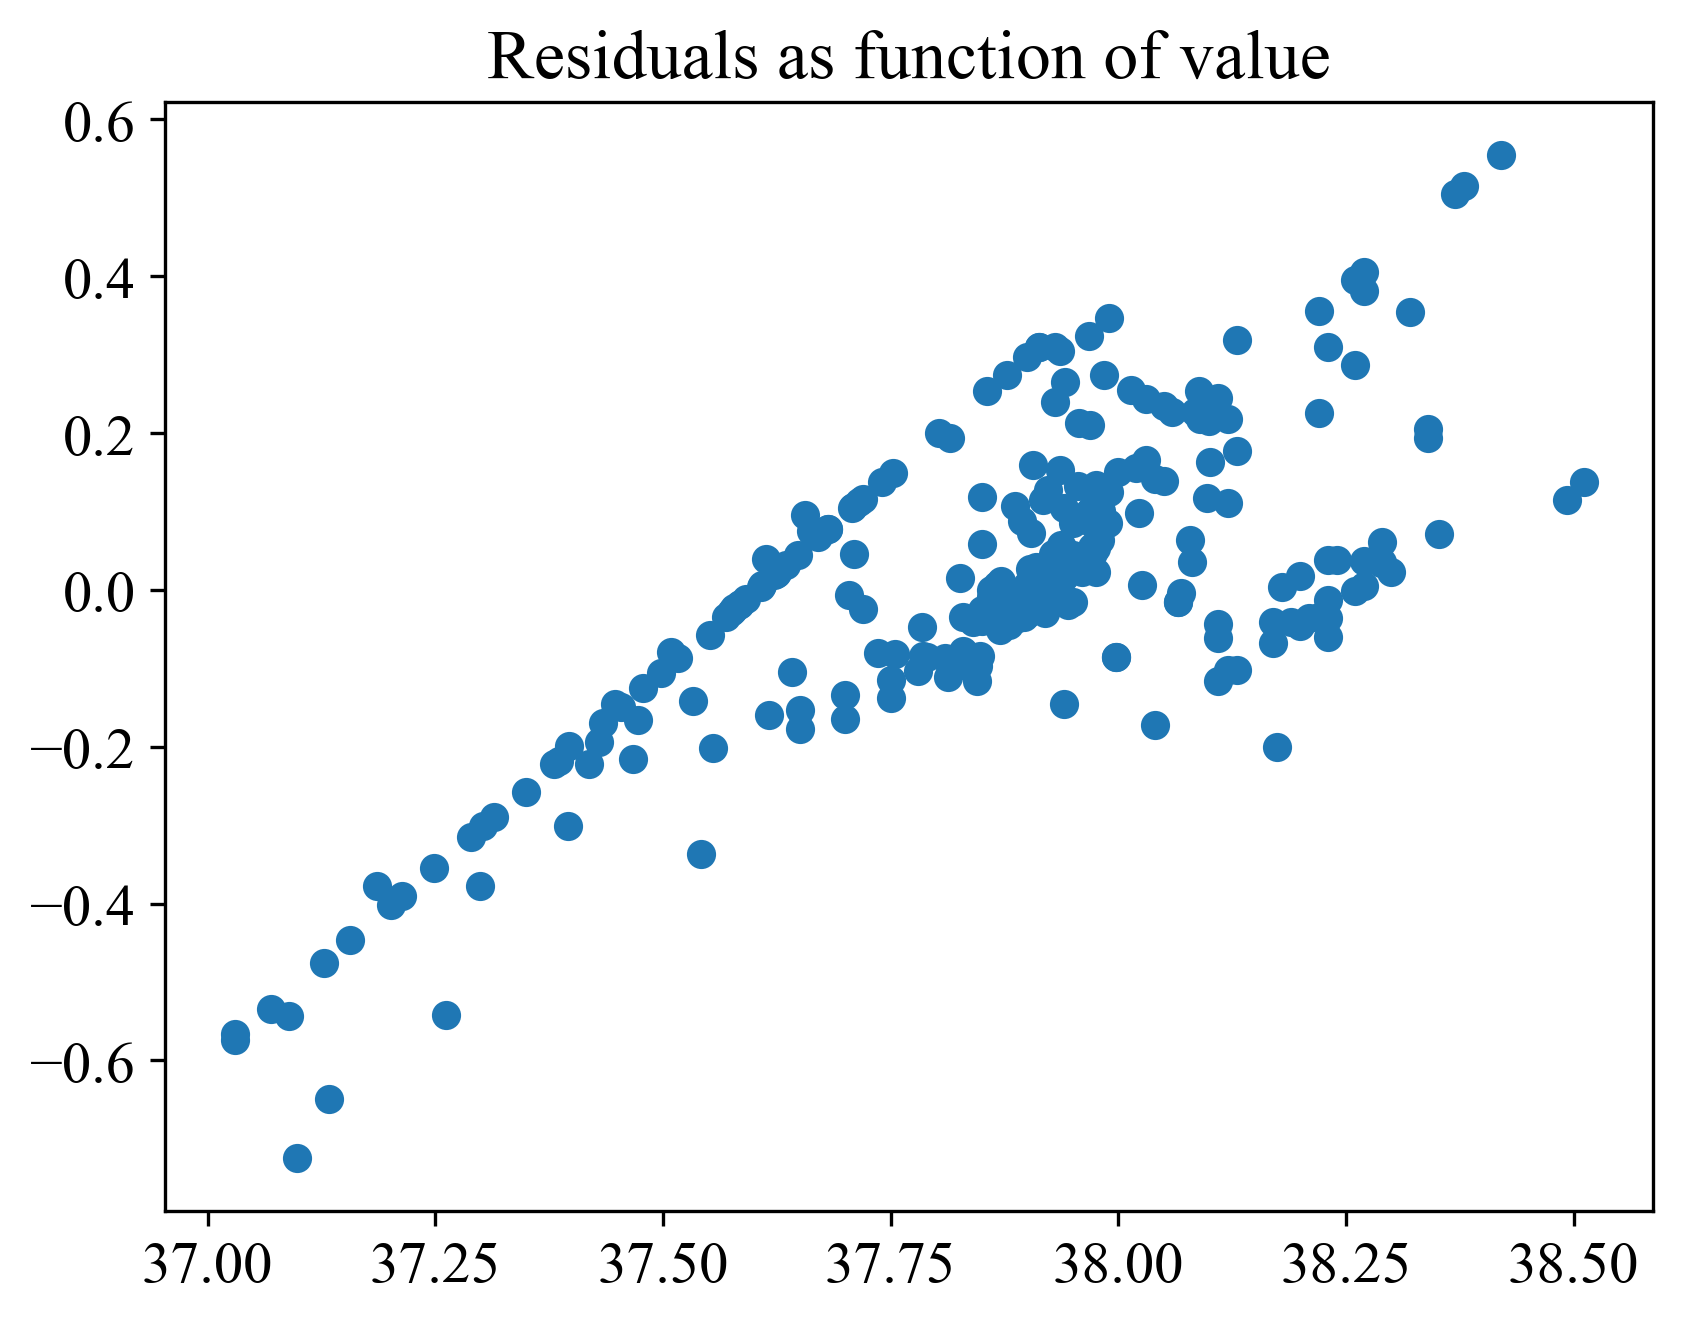

In [19]:
figure()
pcolor(xi,yi,fi+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand_residualobs(s,fi)
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5)

rscale=sqrt(var(obsval))

figure()
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

figure()
scatter(obsval,dataresiduals)
title("Residuals as function of value");

## Adaptive method

G. DESROZIERS, L. BERRE, B. CHAPNIK and P. POLI      
Diagnosis of observation, background and analysis-error statistics in observation space        Q. J. R. Meteorol. Soc. (2005), 131, pp. 3385–3396 doi: [10.1256/qj.05.108](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.05.108).

This adaptive method activated by call with 0,0 points to sample.

In [21]:
myiterations=7
cvbest2=zeros(myiterations);
eps2=zeros(myiterations)
epsilon2=1
for i=1:myiterations
    cvval,factor=divand_cv(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),lenfixed,epsilon2*rdiag,0,0,3);
    eps2[i]=epsilon2;
    cvbest2[i]=cvval;
    epsilon2=epsilon2*factor
    @show epsilon2
end

epsilon2 = 0.19895977962394332
epsilon2 = 0.12232046910060944
epsilon2 = 0.10773511971840544


epsilon2 = 0.10433813169649274
epsilon2 = 0.10350547530280658
epsilon2 = 0.10329875968996342


epsilon2 = 0.10324727706297344


Other direct application of Desroziers

In [22]:
myiterations=7

eps2=zeros(myiterations)
epsilon2=1
for i=1:myiterations
    fit,sit=divandrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval-mean(obsval),lenfixed,epsilon2*rdiag);
    eps2[i]=epsilon2;
    factor=divand_adaptedeps2(sit,fit)
    epsilon2=epsilon2*factor
    @show epsilon2
end

epsilon2 = 0.19895977962394332
epsilon2 = 0.12232046910060944
epsilon2 = 0.10773511971840544
epsilon2 = 0.10433813169649274
epsilon2 = 0.10350547530280658
epsilon2 = 0.10329875968996342
epsilon2 = 0.10324727706297344


Perform a new analysis with the optimized value of $\epsilon^2$:

In [ ]:
newl=lenfixed
newe=epsilon2
@show newe
fi,s = divandrun(mask,(pm,pn),(xi,yi),(lon,lat),value-mean(value),newl,newe*rdiag);

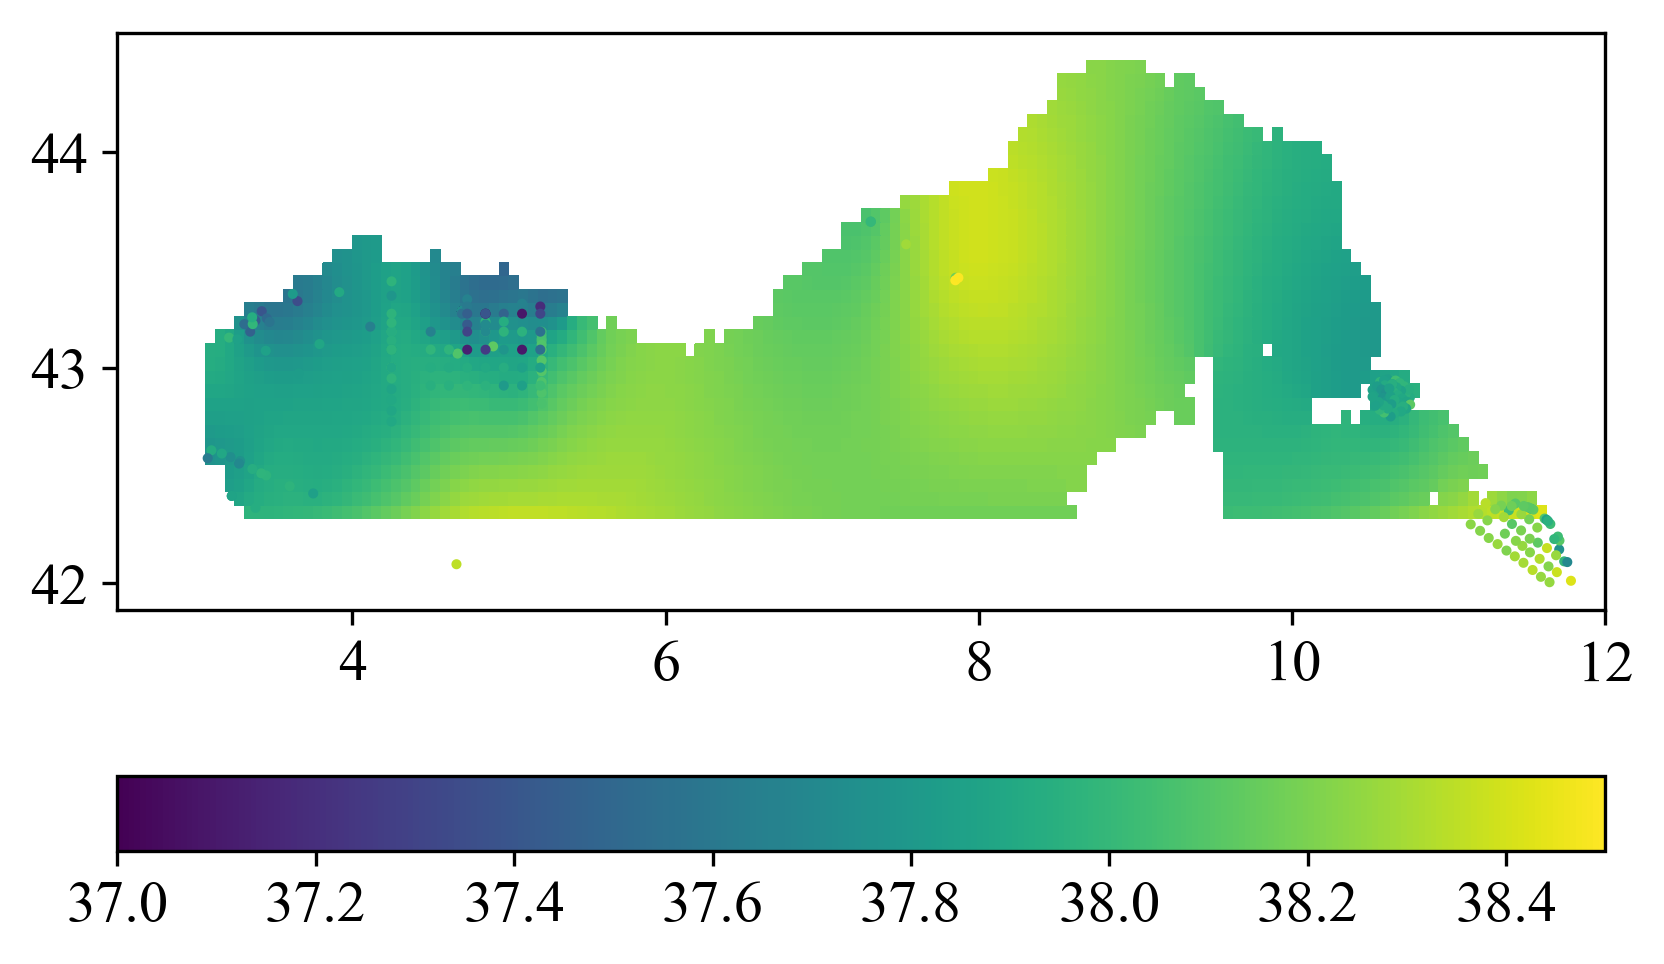

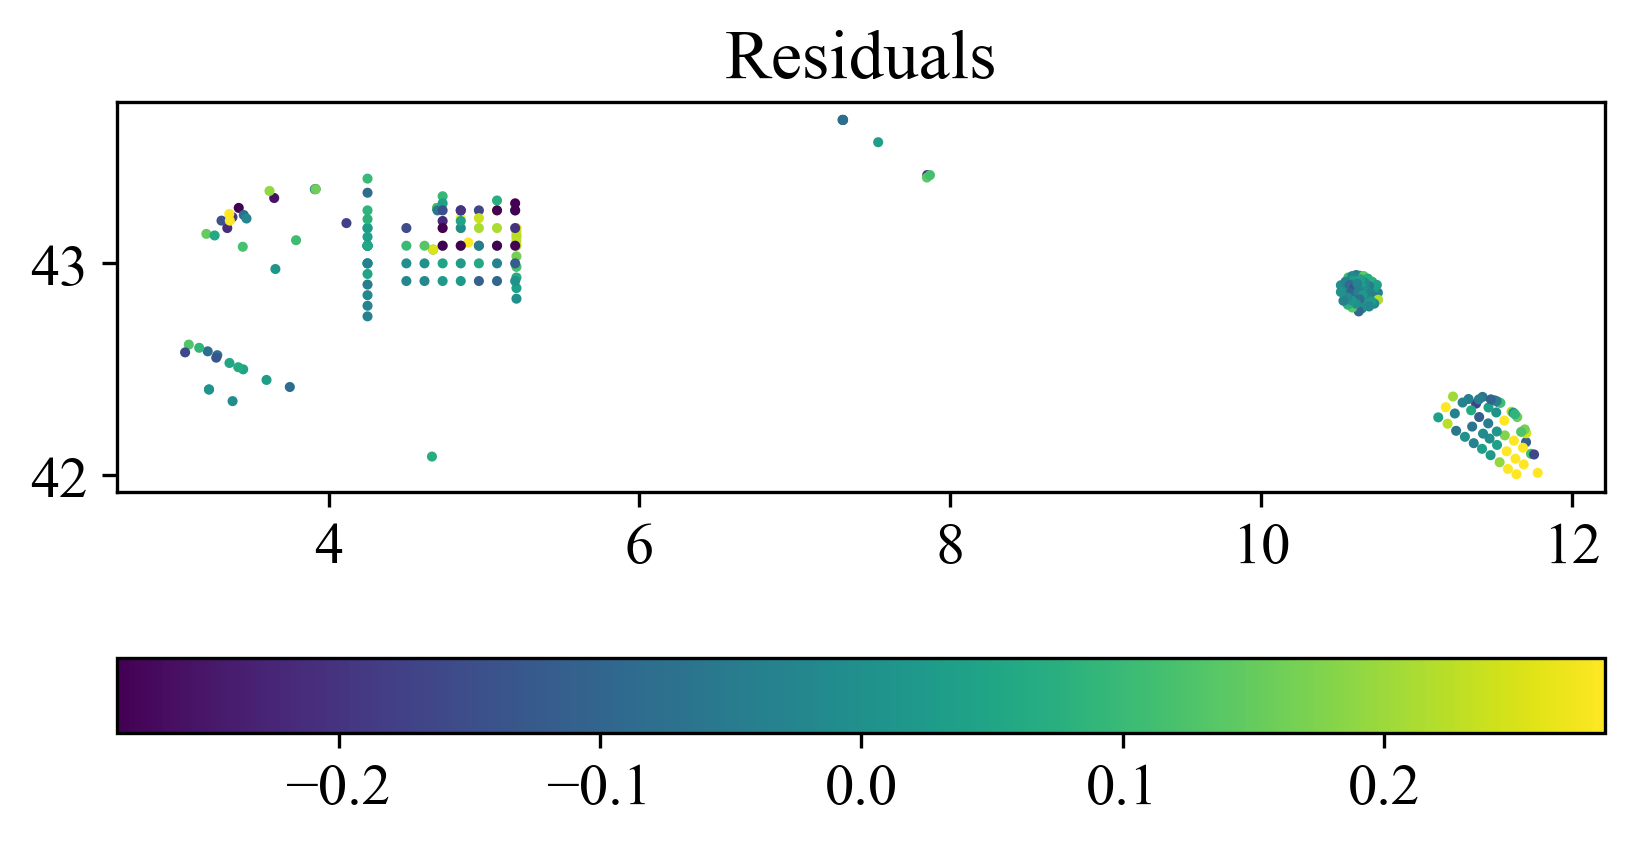

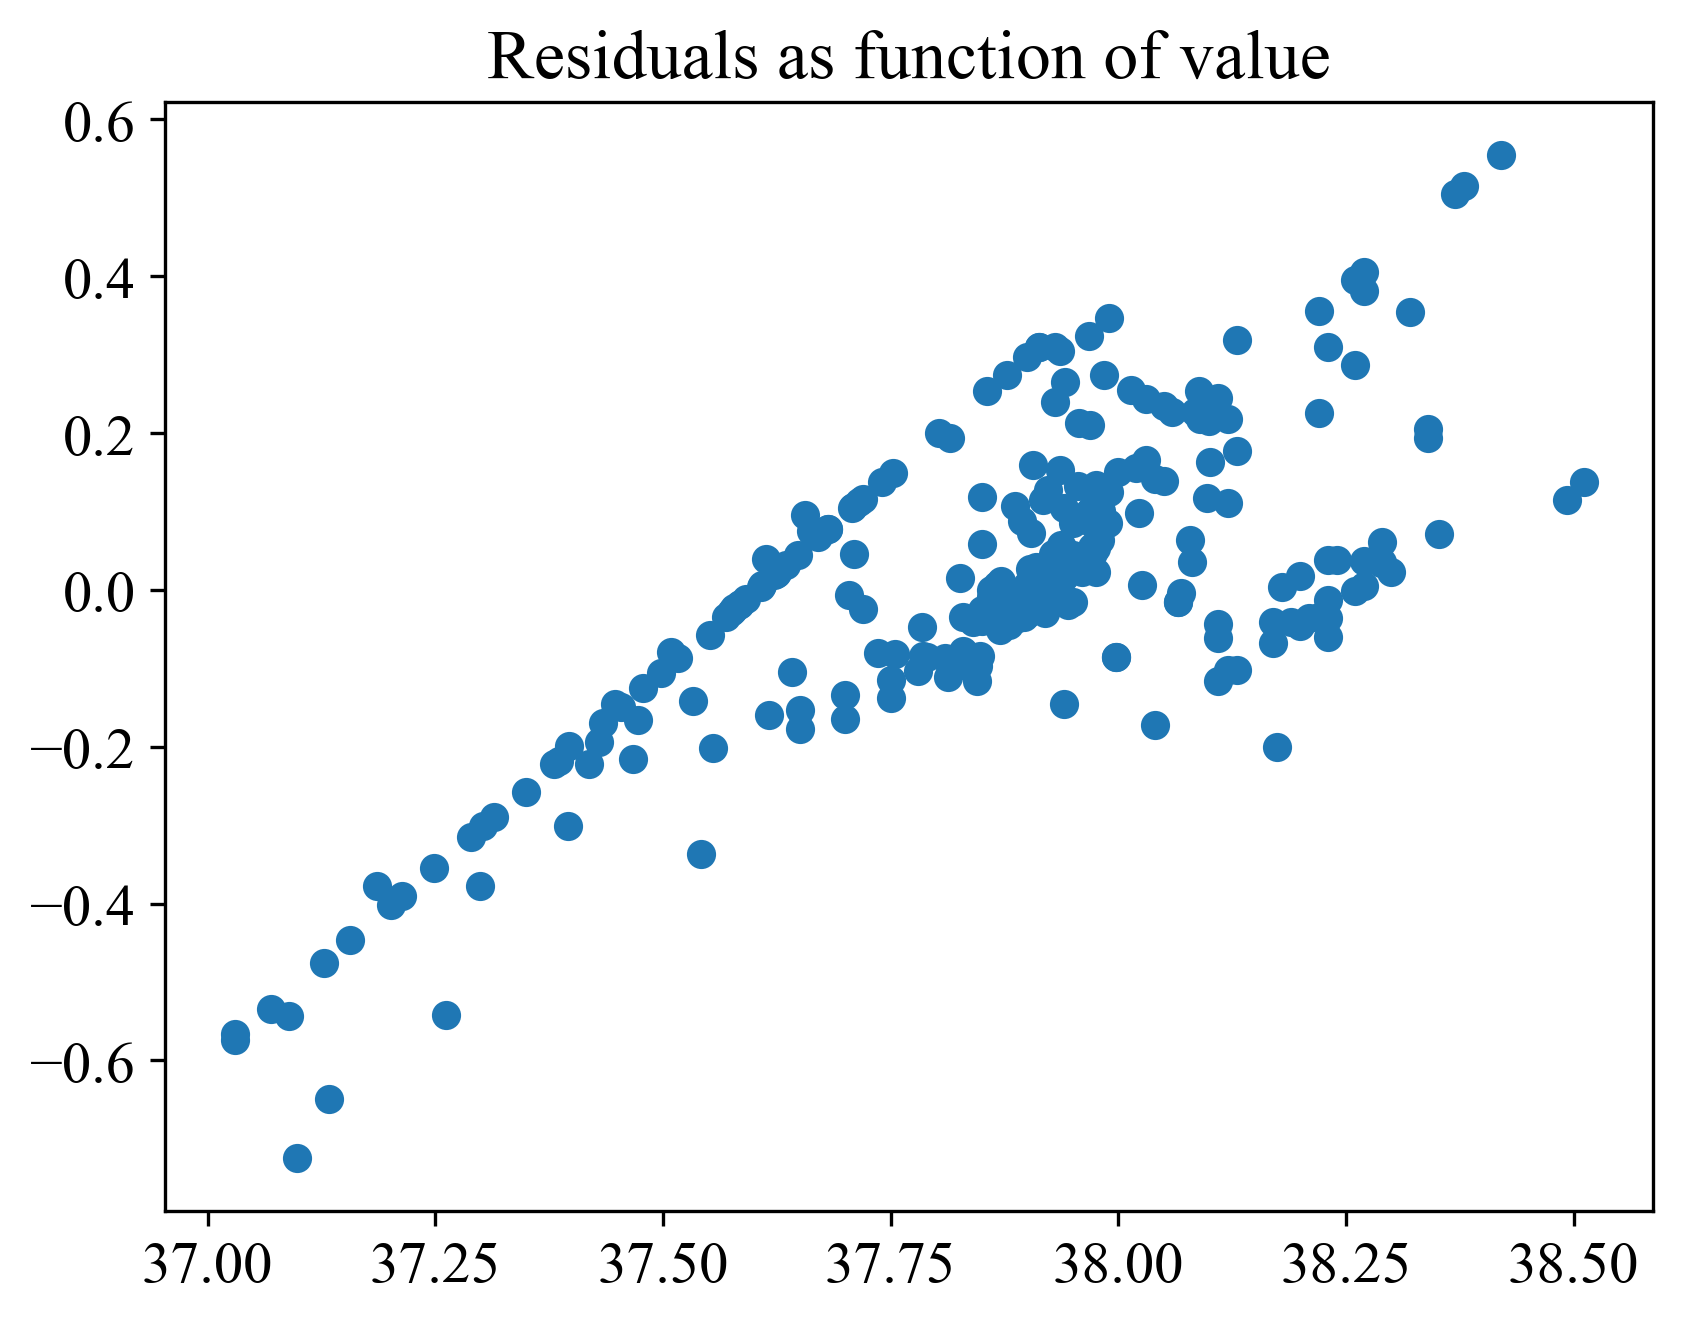

In [25]:
figure()
pcolor(xi,yi,fi+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=divand_residualobs(s,fi)
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5)

rscale=sqrt(var(obsval))

figure()
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

figure()
scatter(obsval,dataresiduals)
title("Residuals as function of value");

In [26]:
var(dataresiduals),var(obsval),var(fi[(fi.!==NaN)])

(0.03540915613510234, 0.08110121763193792, 0.0323049111075827)

## More information

using divand

In [27]:
?divand_cv

search: divand_cv divand_cvestimator divand_GCVKii divand_GCVKiiobs



```
bestfactorl,bestfactore, cvval,cvvalues, x2Ddata,y2Ddata,cvinter,xi2D,yi2D = divand_cv(mask,pmn,xi,x,f,len,epsilon2,nl,ne,method;...);
```

# Input

Same as for `divandrun` with three more parameters `nl`,`ne` and `method`

  * `mask`: binary mask delimiting the domain. true is inside and false outside. For oceanographic application, this is the land-sea mask.
  * `pmn`: scale factor of the grid. pmn is a tuple with n elements. Every      element represents the scale factor of the corresponding dimension. Its      inverse is the local resolution of the grid in a particular dimension.
  * `xi`: tuple with n elements. Every element represents a coordinate of the final grid on which the observations are interpolated
  * `x`: tuple with n elements. Every element represents a coordinate of the observations
  * `f`: value of the observations *minus* the background estimate (m-by-1 array).   (see note)
  * `len`: correlation length
  * `epsilon2`: error variance of the observations (normalized by the error variance of the background field). `epsilon2` can be a scalar (all observations have the same error variance and their errors are decorrelated), a vector (all observations can have a difference error variance and their errors are decorrelated) or a matrix (all observations can have a difference error variance and their errors can be correlated). If `epsilon2` is a scalar, it is thus the *inverse of the signal-to-noise ratio*.
  * `nl`: number of testing points around the current value of L. `1` means one additional point on both sides of the current L. `0` is allowed and means the parameter is not optimised.
  * `ne`: number of testing points around the current value of epsilon2. `0` is allowed as for `nl`
  * `method`: cross validation estimator method 1: full CV  2: sampled CV 3: GCV 0: automatic choice between the three possible ones, default value
  * Optional input arguments specified via keyword arguments are the same as for `divand`

# Output:

  * `bestfactorl`: best estimate of the multiplication factor to apply to len
  * `bestfactore`: best estimate of the multiplication factor to apply to epsilon2
  * `cvvales` : the cross validation values calculated
  * `factors` : the tested multiplication factors
  * `cvinter` : interpolated cv values for final optimisation
  * `X2Data, Y2Data` : coordinates of sampled cross validation in `L,epsilon2` space . Normally only used for debugging or plotting
  * `Xi2D, Yi2D` : coordinates of interpolated estimator . Normally only used for debugging or plotting

The output `bestfactorl` and `bestfactore` represent multiplication factors which should be applied to `L` and `epsilon2`.

The `len` and `epsilon2` provided should be close the real one as the tests will be performed around.


=========================================================================================================================

# Exercise

1. Redo for different data by changing the datadepth parameter introduced in the data selection part.      
(Compare surface behaviour with deeper regions by using another `datadepth` value).
2. Take out the data weight modification.
3. Possibly force the cross-validation method (use `?divand_cv`).
4. Once opimized, try to redo optimization with starting point being the first estimate.

# Remember: optimization relies on a series of hypotheses. In particular, data independance and isotropy is very often NOT ensured. When in doubt, increase $\epsilon^2$ and/or check for "duplicates".